### Import necessary modules

In [1]:
# For data processing
import numpy as np
import pandas as pd

# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For Model
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

# For progress bar
from tqdm import tqdm

# For handling json files
import json

### Helper functions

In [2]:
def create_model(hidden_layer_units, input_dim, dropout=False, dropout_rate=0.2, model_name='model'):
    """
    Creates a neural network classifier model with:
        - l hidden layers, where l is len(hidden_layer_units)
        - hidden_layer_units[i] units for i'th layer
        - Binary Crossentropy loss
        - Adam optimizer
        - Accuracy, precision, and recall metrics
        - Dropout in each layer (optional)
        - Model name model_name
    
    Returns the compiled model.
    """
    
    model = Sequential(name=model_name)
    
    # Input layer
    model.add(Dense(hidden_layer_units[0], 
                    activation='relu', 
                    input_dim=input_dim,
                    name='Dense_1'))
    
    if dropout == True:
        model.add(Dropout(dropout_rate, name='Dropout_1'))    
    
    # Add the hidden layers
    l = 2
    for units in hidden_layer_units[1:]:
        model.add(Dense(units, activation='relu', name=f'Dense_{l}'))
        l += 1
        
        if dropout == True:
            model.add(Dropout(dropout_rate, name=f'Dropout_{l}'))
    
    # Output layer (sigmoid outputs [0, 1])
    model.add(Dense(1, activation='sigmoid', name='Output'))
    
    model.compile(loss='binary_crossentropy', optimizer='adam', 
                  metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])
    
    return model


def visualize_performance(y_train, y_train_pred, y_test, y_test_pred):
    """
    Creates a confusion matrix visualization for train and test set
    using heatmap with added information such as:
        - Accuracy
        - Precision
        - Recall
        - F1 score
        
    Returns the accuracy, precision, recall, and F1 score from test set.
    """
    
    f, ax = plt.subplots(ncols=2, figsize=(14, 4))
    f.suptitle('Training vs Test Performance', fontweight='bold', fontsize='x-large')
    
    # Training set
    cf_train = confusion_matrix(y_train, y_train_pred)
    sns.heatmap(cf_train, fmt='.0f', annot=True, ax=ax[0])
    
    # Calculate metrics
    accuracy_train = np.trace(cf_train) / float(np.sum(cf_train))
    precision_train = cf_train[1,1] / sum(cf_train[:,1])
    recall_train = cf_train[1,1] / sum(cf_train[1,:])
    f1_score_train = 2 * precision_train * recall_train / (precision_train + recall_train)
    
    stats_text_train = "\n\nAccuracy={:0.2f}\nPrecision={:0.2f}\nRecall={:0.2f}\nF1 Score={:0.2f}".format(
        accuracy_train, precision_train, recall_train, f1_score_train)
    
    ax[0].set(xlabel='Predicted' + stats_text_train, 
              ylabel='Actual', title='Training Performance')
    
    # Test set
    cf_test = confusion_matrix(y_test, y_test_pred)
    sns.heatmap(cf_test, fmt='.0f', annot=True, ax=ax[1])
    
    # Calculate metrics
    accuracy_test = np.trace(cf_test) / float(np.sum(cf_test))
    precision_test = cf_test[1,1] / sum(cf_test[:,1])
    recall_test = cf_test[1,1] / sum(cf_test[1,:])
    f1_score_test = 2 * precision_test * recall_test / (precision_test + recall_test)
    
    stats_text_test = "\n\nAccuracy={:0.2f}\nPrecision={:0.2f}\nRecall={:0.2f}\nF1 Score={:0.2f}".format(
        accuracy_test, precision_test, recall_test, f1_score_test)
    
    ax[1].set(xlabel='Predicted' + stats_text_test, 
              ylabel='Actual', title='Test Performance')
    
    plt.show()
    
    return accuracy_test, precision_test, recall_test, f1_score_test


def test_performance(y_test, y_test_pred):
    """ 
    Returns the accuracy, precision, recall, and F1 score from test set.
    """

    # Test set
    cf_test = confusion_matrix(y_test, y_test_pred)
    
    # Calculate metrics
    accuracy_test = np.trace(cf_test) / float(np.sum(cf_test))
    precision_test = cf_test[1,1] / sum(cf_test[:,1])
    recall_test = cf_test[1,1] / sum(cf_test[1,:])
    f1_score_test = 2 * precision_test * recall_test / (precision_test + recall_test)
    
    return accuracy_test, precision_test, recall_test, f1_score_test


def visualize_training_history(history):
    """
    Creates a visualization of model's training process that contains:
        - Loss
        - Accuracy
        - Precision
        - Recall
    """
    f, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 12))
    f.suptitle('Training History', fontweight='bold', fontsize='x-large')
    
    ax[0][0].plot(history.history['loss'], label='Loss (training data)')
    ax[0][0].set_title('Loss History')
    ax[0][0].set(ylabel='Loss', xlabel='Number of Epochs')
    ax[0][0].legend(loc="upper right")

    ax[0][1].plot(history.history['accuracy'], label='Accuracy (training data)')
    ax[0][1].set_title('Accuracy History')
    ax[0][1].set(ylabel='Loss', xlabel='Number of Epochs')
    ax[0][1].legend(loc="lower right")    
    
    ax[1][0].plot(history.history['precision'], label='Precision (training data)')
    ax[1][0].set_title('Precision History')
    ax[1][0].set(ylabel='Precision', xlabel='Number of Epochs')
    ax[1][0].legend(loc="lower right")
        
    ax[1][1].plot(history.history['recall'], label='Recall (training data)')
    ax[1][1].set_title('Recall History')
    ax[1][1].set(ylabel='Precision', xlabel='Number of Epochs')
    ax[1][1].legend(loc="lower right")

    
def visualize_multiple_training_histories(training_histories):
    """
    Creates a visualization of training histories from different resampling methods.
    
    Input: dictionary (key -> metric, value -> history callback)
    """
    
    
    f, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 12))
    f.suptitle('Training Histories Between Different Resampling Methods'
               , fontweight='bold', fontsize='x-large')
    
    # Set title and labels for each axis
    ax[0][0].set_title('Loss History')
    ax[0][0].set(ylabel='Loss', xlabel='Number of Epochs')

    ax[1][0].set_title('Precision History')
    ax[1][0].set(ylabel='Precision', xlabel='Number of Epochs')

    ax[0][1].set_title('Accuracy History')
    ax[0][1].set(ylabel='Loss', xlabel='Number of Epochs')

    ax[1][1].set_title('Recall History')
    ax[1][1].set(ylabel='Precision', xlabel='Number of Epochs')
    
    # Plotting data
    for metric, cb in training_histories.items():
        ax[0][0].plot(cb.history['loss'], label=metric)
        ax[0][0].legend(loc="upper right")
        
        ax[0][1].plot(cb.history['accuracy'], label=metric)
        ax[0][1].legend(loc="lower right")
        
        ax[1][0].plot(cb.history['precision'], label=metric)
        ax[1][0].legend(loc="lower right")
        
        ax[1][1].plot(cb.history['recall'], label=metric)
        ax[1][1].legend(loc="lower right")
        
    plt.show()
    

def visualize_tests_performance(tests_performance):
    """
    Display 4 barplots comparing:
        - Accuracy
        - Precision
        - Recall
        - F1 Score
    on test sets between different resampling methods.
    """
    
    f, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 12))
    f.suptitle('Tests Performance Between Different Resampling Methods'
               , fontweight='bold', fontsize='x-large')
    
    i = 0
    for metric, ls in tests_performance.items():
        # Takes the labels
        x = pd.DataFrame(ls).T.iloc[0].to_list()
        # Takes the values
        y = pd.DataFrame(ls).T.iloc[1].to_list()
        
        plot = sns.barplot(x=x, y=y, ax=ax[i // 2][i % 2])
        
        # Show the actual numbers on the barplots
        for p in plot.patches:
            plot.annotate(format(p.get_height(), '.2f'), 
                           (p.get_x() + p.get_width() / 2., p.get_height()), 
                           ha = 'center', 
                           va = 'center', 
                           xytext = (0, 10), 
                           textcoords = 'offset points')
        
        ax[i // 2][i % 2].set(title=metric)
        ax[i // 2][i % 2].set_ylim(0, 1)
        
        i += 1
    
    plt.show()
    

def standardize(X_train, X_test):
    """
    Standardize the inputs of the train and test set.
    
    Returns the standardized inputs.
    """
    scaler = StandardScaler()
    X_train_std = scaler.fit_transform(X_train)
    X_test_std = scaler.transform(X_test)
    
    return X_train_std, X_test_std


def repeat_train_and_test(iterations=50):
    
    template = {'Original': 0, 'Oversampling': 0, 'SMOTETomek': 0, 'SMOTEENN': 0}
    # To count the winners for each metric in all iterations
    winner_count = {'Test Accuracy': template.copy(), 
                    'Test Precision': template.copy(), 
                    'Test Recall': template.copy(), 
                    'Test F1 Score': template.copy()}
    
    for i in tqdm(range(iterations)):
        # To store the values of each metric in a single iteration
        tests_performance = {'Test Accuracy': [], 
                             'Test Precision': [], 
                             'Test Recall': [], 
                             'Test F1 Score': []}

        ## 1. First Model (Original)

        # Import and prepare dataset
        train_stroke_data = pd.read_csv('train.csv', index_col=0)
        train_stroke_data = train_stroke_data.drop(columns=['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'])

        test_stroke_data = pd.read_csv('test.csv', index_col=0)
        test_stroke_data = test_stroke_data.drop(columns=['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'])

        # Split into X and y
        X_train, y_train = train_stroke_data.iloc[:, :-1], train_stroke_data.iloc[:, -1]
        X_test, y_test = test_stroke_data.iloc[:, :-1], test_stroke_data.iloc[:, -1]

        # Standardize inputs
        X_train, X_test = standardize(X_train, X_test)

        # Create NN model
        model = create_model([16, 16, 16], input_dim=len(X_train[0]), model_name='original-model')

        # Model training
        history = model.fit(X_train, y_train, batch_size=16, epochs=100, verbose=0)
        training_histories['Original'] = history

        # Model performance on train and test set
        y_train_pred = (model.predict(X_train) >= 0.5).astype('int64')
        y_test_pred = (model.predict(X_test) >= 0.5).astype('int64')

        accuracy, precision, recall, f1_score = test_performance(y_test, y_test_pred)

        tests_performance['Test Accuracy'].append(('Original', accuracy))
        tests_performance['Test Precision'].append(('Original', precision))
        tests_performance['Test Recall'].append(('Original', recall))
        tests_performance['Test F1 Score' ].append(('Original', f1_score))

        
        ## 2. Second Model (Oversampling)

        # Import and prepare dataset
        train_stroke_data = pd.read_csv('oversampled-train.csv', index_col=0)
        train_stroke_data = train_stroke_data.drop(columns=['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'])

        test_stroke_data = pd.read_csv('test.csv', index_col=0)
        test_stroke_data = test_stroke_data.drop(columns=['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'])

        # Split into X and y
        X_train, y_train = train_stroke_data.iloc[:, :-1], train_stroke_data.iloc[:, -1]
        X_test, y_test = test_stroke_data.iloc[:, :-1], test_stroke_data.iloc[:, -1]

        # Standardize inputs
        X_train, X_test = standardize(X_train, X_test)

        # Create NN model
        model = create_model([16, 16, 16], input_dim=len(X_train[0]), model_name='oversampling-model')

        # Model training
        history = model.fit(X_train, y_train, batch_size=16, epochs=100, verbose=0)
        training_histories['Oversampling'] = history

        # Model performance on train and test sets
        y_train_pred = (model.predict(X_train) >= 0.5).astype('int64')
        y_test_pred = (model.predict(X_test) >= 0.5).astype('int64')

        accuracy, precision, recall, f1_score = test_performance(y_test, y_test_pred)

        tests_performance['Test Accuracy'].append(('Oversampling', accuracy))
        tests_performance['Test Precision'].append(('Oversampling', precision))
        tests_performance['Test Recall'].append(('Oversampling', recall))
        tests_performance['Test F1 Score' ].append(('Oversampling', f1_score))

        ## 3. Third Model (SMOTETomek Resampling)

        # Import and prepare dataset
        train_stroke_data = pd.read_csv('smotetomek-train.csv', index_col=0)
        train_stroke_data = train_stroke_data.drop(columns=['hypertension', 'heart_disease', 'stroke'])

        test_stroke_data = pd.read_csv('test.csv', index_col=0)
        test_stroke_data = test_stroke_data.drop(columns=['hypertension', 'heart_disease', 'stroke', 'gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'])

        # Split into X and y
        X_train, y_train = train_stroke_data.iloc[:, :-1], train_stroke_data.iloc[:, -1]
        X_test, y_test = test_stroke_data.iloc[:, :-1], test_stroke_data.iloc[:, -1]

        # Standardize inputs
        X_train, X_test = standardize(X_train, X_test)

        # Create NN model
        model = create_model([16, 16, 16], input_dim=len(X_train[0]), model_name='smotetomek-model')

        # Model training
        history = model.fit(X_train, y_train, batch_size=16, epochs=100, verbose=0)
        training_histories['SMOTETomek'] = history


        # Model performance on train and test set
        y_train_pred = (model.predict(X_train) >= 0.5).astype('int64')
        y_test_pred = (model.predict(X_test) >= 0.5).astype('int64')

        accuracy, precision, recall, f1_score = test_performance(y_test, y_test_pred)
        
        tests_performance['Test Accuracy'].append(('SMOTETomek', accuracy))
        tests_performance['Test Precision'].append(('SMOTETomek', precision))
        tests_performance['Test Recall'].append(('SMOTETomek', recall))
        tests_performance['Test F1 Score' ].append(('SMOTETomek', f1_score))

        ## 4. Fourth Model (SMOTEENN Resampling)

        # Import and prepare dataset
        train_stroke_data = pd.read_csv('smoteenn-train.csv', index_col=0)
        train_stroke_data = train_stroke_data.drop(columns=['hypertension', 'heart_disease', 'stroke'])

        test_stroke_data = pd.read_csv('test.csv', index_col=0)
        test_stroke_data = test_stroke_data.drop(columns=['hypertension', 'heart_disease', 'stroke', 'gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'])

        # Split into X and y
        X_train, y_train = train_stroke_data.iloc[:, :-1], train_stroke_data.iloc[:, -1]
        X_test, y_test = test_stroke_data.iloc[:, :-1], test_stroke_data.iloc[:, -1]

        # Standardize inputs
        X_train, X_test = standardize(X_train, X_test)

        # Create NN model
        model = create_model([16, 16, 16], input_dim=len(X_train[0]),
                             model_name='smoteenn-model')

        # Model training
        history = model.fit(X_train, y_train, batch_size=16, epochs=100, verbose=0)
        training_histories['SMOTEENN'] = history

        # Model performance on train and test set
        y_train_pred = (model.predict(X_train) >= 0.5).astype('int64')
        y_test_pred = (model.predict(X_test) >= 0.5).astype('int64')

        accuracy, precision, recall, f1_score = test_performance(y_test, y_test_pred)

        tests_performance['Test Accuracy'].append(('SMOTEENN', accuracy))
        tests_performance['Test Precision'].append(('SMOTEENN', precision))
        tests_performance['Test Recall'].append(('SMOTEENN', recall))
        tests_performance['Test F1 Score' ].append(('SMOTEENN', f1_score))
        
        # Find the winners for all metrics
        for metric, ls in tests_performance.items():
            # Get the resampling method name that has the maximum value
            winner_name = max(map(lambda x: x[::-1], ls))[1]
            winner_count[metric][winner_name] += 1
            
    return winner_count


def visualize_winner_count(winner_count):
    """
    Displays 4 barplots containing how many times does each resampling method
    did the best compared to other methods after multiple iterations for each metric.
    """

    f, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
    f.suptitle('Number of Wins Between Different Resampling Methods After Multiple Iterations'
               , fontweight='bold', fontsize='x-large')

    i = 0
    for metric, count in winner_count.items():
        # Takes the labels
        x = list(count.keys())
        # Takes the values
        y = list(count.values())

        plot = sns.barplot(x=x, y=y, ax=ax[i // 2][i % 2])
        for p in plot.patches:
            plot.annotate(format(p.get_height(), '.0f'), 
                           (p.get_x() + p.get_width() / 2., p.get_height()), 
                           ha = 'center', 
                           va = 'center', 
                           xytext = (0, 10), 
                           textcoords = 'offset points')

        ax[i // 2][i % 2].set(title=f'{metric} Win Count', ylabel='Win Count')
        ax[i // 2][i % 2].set_ylim(0, 110)

        i += 1

    plt.show()

### Model training

In [3]:
# To store training histories of different resampling methods
training_histories = {}
tests_performance = {'Test Accuracy': [], 
                     'Test Precision': [], 
                     'Test Recall': [], 
                     'Test F1 Score': []}

### 1. First Model (Original)

#### Data preparation

In [4]:
# Import and prepare dataset
train_stroke_data = pd.read_csv('train.csv', index_col=0)
train_stroke_data = train_stroke_data.drop(columns=['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'])
#train_df = train_df.drop(columns=['decade_released', 'genres', 'revenue'])

test_stroke_data = pd.read_csv('test.csv', index_col=0)
test_stroke_data = test_stroke_data.drop(columns=['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'])

# Split into X and y
X_train, y_train = train_stroke_data.iloc[:, :-1], train_stroke_data.iloc[:, -1]
X_test, y_test = test_stroke_data.iloc[:, :-1], test_stroke_data.iloc[:, -1]

# Standardize inputs
X_train, X_test = standardize(X_train, X_test)

#### Create model

In [5]:
# Create NN model
model = create_model([16, 16, 16], input_dim=len(X_train[0]), model_name='original-model')
model.summary()

Model: "original-model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_1 (Dense)             (None, 16)                96        
                                                                 
 Dense_2 (Dense)             (None, 16)                272       
                                                                 
 Dense_3 (Dense)             (None, 16)                272       
                                                                 
 Output (Dense)              (None, 1)                 17        
                                                                 
Total params: 657
Trainable params: 657
Non-trainable params: 0
_________________________________________________________________


#### Model training

In [6]:
history = model.fit(X_train, y_train, batch_size=16, epochs=100)

# Save training history
training_histories['Original'] = history

Epoch 1/100
256/256 [==============================] - 2s 3ms/step - loss: 0.4877 - accuracy: 0.8085 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 2/100
256/256 [==============================] - 1s 3ms/step - loss: 0.4540 - accuracy: 0.8085 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 3/100
256/256 [==============================] - 1s 3ms/step - loss: 0.4502 - accuracy: 0.8085 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 4/100
256/256 [==============================] - 1s 3ms/step - loss: 0.4481 - accuracy: 0.8085 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 5/100
256/256 [==============================] - 1s 3ms/step - loss: 0.4471 - accuracy: 0.8090 - precision: 0.6250 - recall: 0.0064
Epoch 6/100
256/256 [==============================] - 1s 3ms/step - loss: 0.4459 - accuracy: 0.8080 - precision: 0.2500 - recall: 0.0013   
Epoch 7/100
256/256 [==============================] - 1s 3ms/step - loss: 0.4444 - accuracy: 0.8094 - precision: 0.7000 - recall: 0.0089

256/256 [==============================] - 1s 3ms/step - loss: 0.4340 - accuracy: 0.8121 - precision: 0.5688 - recall: 0.0792
Epoch 60/100
256/256 [==============================] - 1s 2ms/step - loss: 0.4341 - accuracy: 0.8109 - precision: 0.5490 - recall: 0.0715
Epoch 61/100
256/256 [==============================] - 1s 3ms/step - loss: 0.4349 - accuracy: 0.8102 - precision: 0.5310 - recall: 0.0766
Epoch 62/100
256/256 [==============================] - 1s 3ms/step - loss: 0.4343 - accuracy: 0.8082 - precision: 0.4959 - recall: 0.0766
Epoch 63/100
256/256 [==============================] - 1s 2ms/step - loss: 0.4341 - accuracy: 0.8114 - precision: 0.5577 - recall: 0.0741
Epoch 64/100
256/256 [==============================] - 1s 2ms/step - loss: 0.4343 - accuracy: 0.8114 - precision: 0.5556 - recall: 0.0766
Epoch 65/100
256/256 [==============================] - 1s 2ms/step - loss: 0.4341 - accuracy: 0.8112 - precision: 0.5505 - recall: 0.0766
Epoch 66/100
256/256 [==================

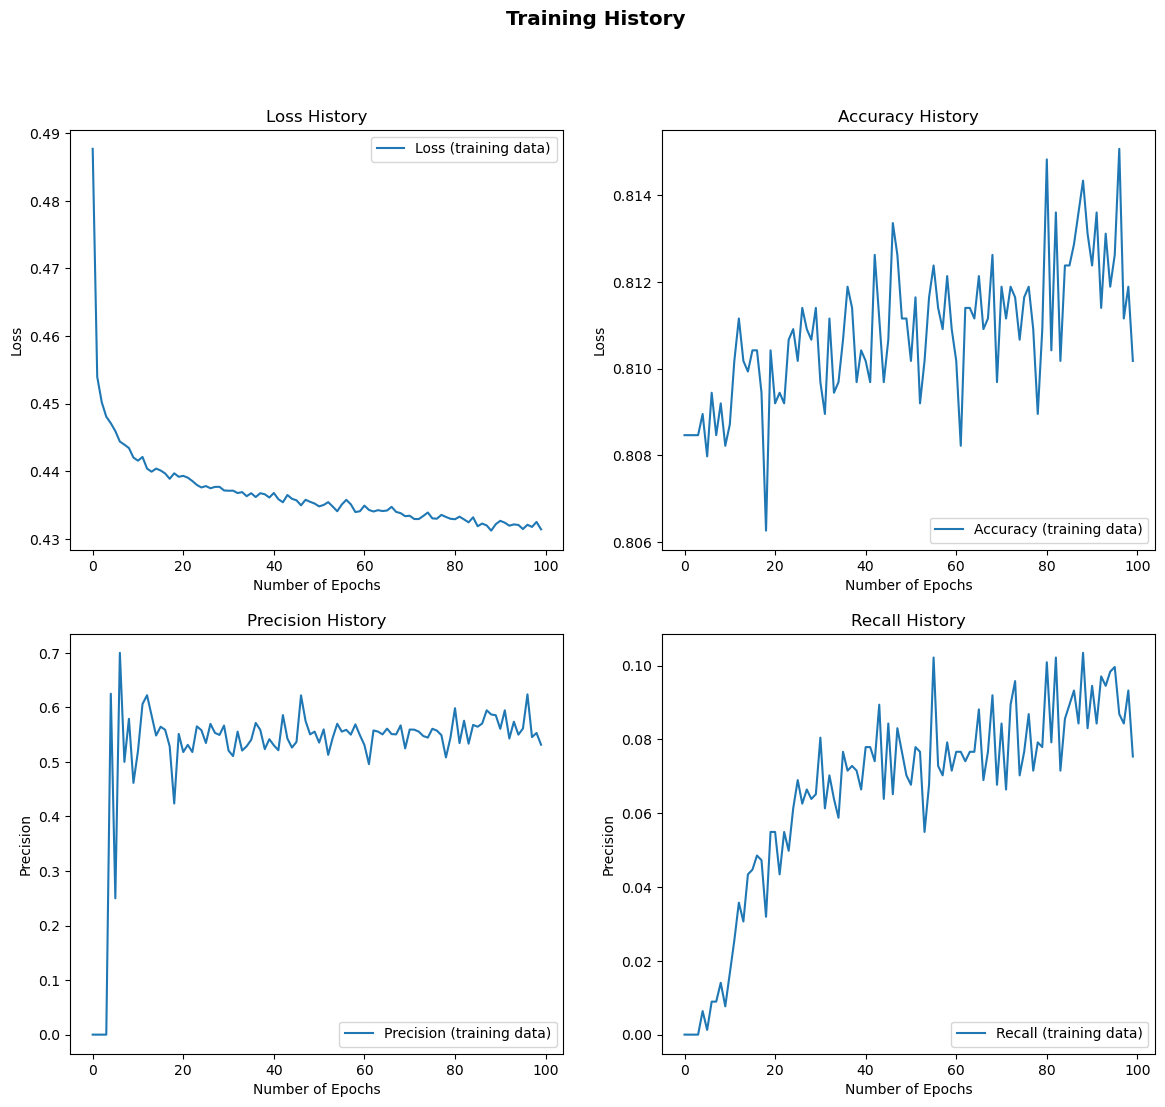

In [7]:
visualize_training_history(history)

#### Model performance on train and test set

32/32 [==============================] - 0s 2ms/step


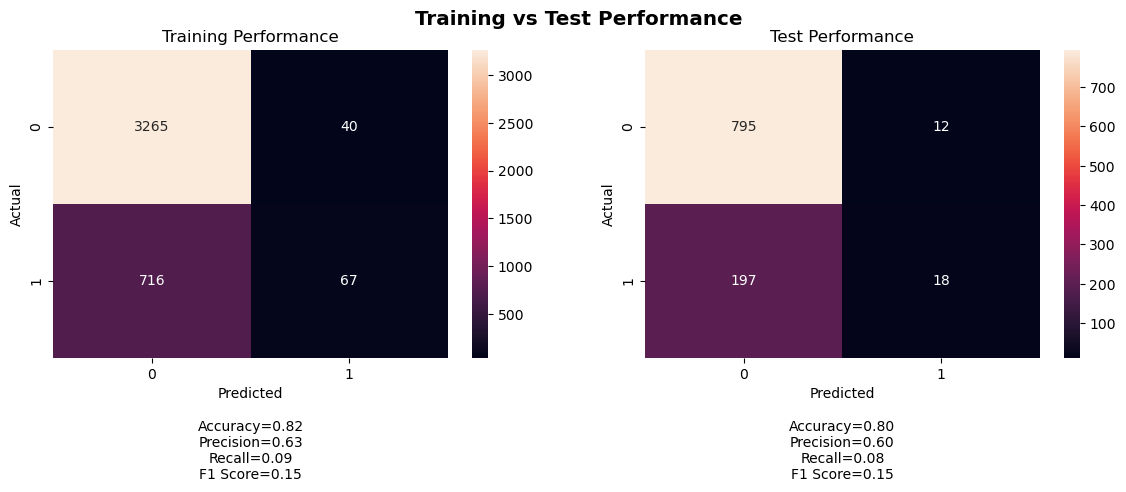

In [8]:
# Change probabilities to 0s and 1s
y_train_pred = (model.predict(X_train) >= 0.5).astype('int64')
y_test_pred = (model.predict(X_test) >= 0.5).astype('int64')

accuracy, precision, recall, f1_score = visualize_performance(y_train, y_train_pred, 
                                                              y_test, y_test_pred)

# Save values
tests_performance['Test Accuracy'].append(('Original', accuracy))
tests_performance['Test Precision'].append(('Original', precision))
tests_performance['Test Recall'].append(('Original', recall))
tests_performance['Test F1 Score' ].append(('Original', f1_score))

### 2. Second Model (Oversampling)

#### Data preparation

In [15]:
# Import and prepare dataset
train_stroke_data = pd.read_csv('oversampled-train.csv', index_col=0)
train_stroke_data = train_stroke_data.drop(columns=['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'])

test_stroke_data = pd.read_csv('test.csv', index_col=0)
test_stroke_data = test_stroke_data.drop(columns=['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'])

# Split into X and y
X_train, y_train = train_stroke_data.iloc[:, :-1], train_stroke_data.iloc[:, -1]
X_test, y_test = test_stroke_data.iloc[:, :-1], test_stroke_data.iloc[:, -1]

# Standardize inputs
X_train, X_test = standardize(X_train, X_test)


#### Create model

In [16]:
# Create NN model
model = create_model([16, 16, 16], input_dim=len(X_train[0]), model_name='oversampling-model')
model.summary()

Model: "oversampling-model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_1 (Dense)             (None, 16)                96        
                                                                 
 Dense_2 (Dense)             (None, 16)                272       
                                                                 
 Dense_3 (Dense)             (None, 16)                272       
                                                                 
 Output (Dense)              (None, 1)                 17        
                                                                 
Total params: 657
Trainable params: 657
Non-trainable params: 0
_________________________________________________________________


#### Model training

In [17]:
# Model training
history = model.fit(X_train, y_train, batch_size=16, epochs=100)
training_histories['Oversampling'] = history

Epoch 1/100
310/310 [==============================] - 2s 3ms/step - loss: 0.6128 - accuracy: 0.6696 - precision: 0.5216 - recall: 0.1023
Epoch 2/100
310/310 [==============================] - 1s 2ms/step - loss: 0.5858 - accuracy: 0.6843 - precision: 0.5694 - recall: 0.2161
Epoch 3/100
310/310 [==============================] - 1s 3ms/step - loss: 0.5802 - accuracy: 0.6909 - precision: 0.5984 - recall: 0.2209
Epoch 4/100
310/310 [==============================] - 1s 2ms/step - loss: 0.5769 - accuracy: 0.6936 - precision: 0.6067 - recall: 0.2288
Epoch 5/100
310/310 [==============================] - 1s 3ms/step - loss: 0.5757 - accuracy: 0.6913 - precision: 0.5984 - recall: 0.2246
Epoch 6/100
310/310 [==============================] - 1s 2ms/step - loss: 0.5734 - accuracy: 0.6956 - precision: 0.6170 - recall: 0.2282
Epoch 7/100
310/310 [==============================] - 1s 3ms/step - loss: 0.5721 - accuracy: 0.6958 - precision: 0.6139 - recall: 0.2349
Epoch 8/100
310/310 [=============

310/310 [==============================] - 1s 3ms/step - loss: 0.5523 - accuracy: 0.7041 - precision: 0.6439 - recall: 0.2506
Epoch 61/100
310/310 [==============================] - 1s 3ms/step - loss: 0.5516 - accuracy: 0.7045 - precision: 0.6445 - recall: 0.2524
Epoch 62/100
310/310 [==============================] - 1s 3ms/step - loss: 0.5523 - accuracy: 0.7043 - precision: 0.6453 - recall: 0.2500
Epoch 63/100
310/310 [==============================] - 1s 3ms/step - loss: 0.5523 - accuracy: 0.7045 - precision: 0.6427 - recall: 0.2548
Epoch 64/100
310/310 [==============================] - 1s 3ms/step - loss: 0.5520 - accuracy: 0.7037 - precision: 0.6469 - recall: 0.2439
Epoch 65/100
310/310 [==============================] - 1s 3ms/step - loss: 0.5526 - accuracy: 0.7030 - precision: 0.6393 - recall: 0.2500
Epoch 66/100
310/310 [==============================] - 1s 3ms/step - loss: 0.5516 - accuracy: 0.7051 - precision: 0.6547 - recall: 0.2433
Epoch 67/100
310/310 [==================

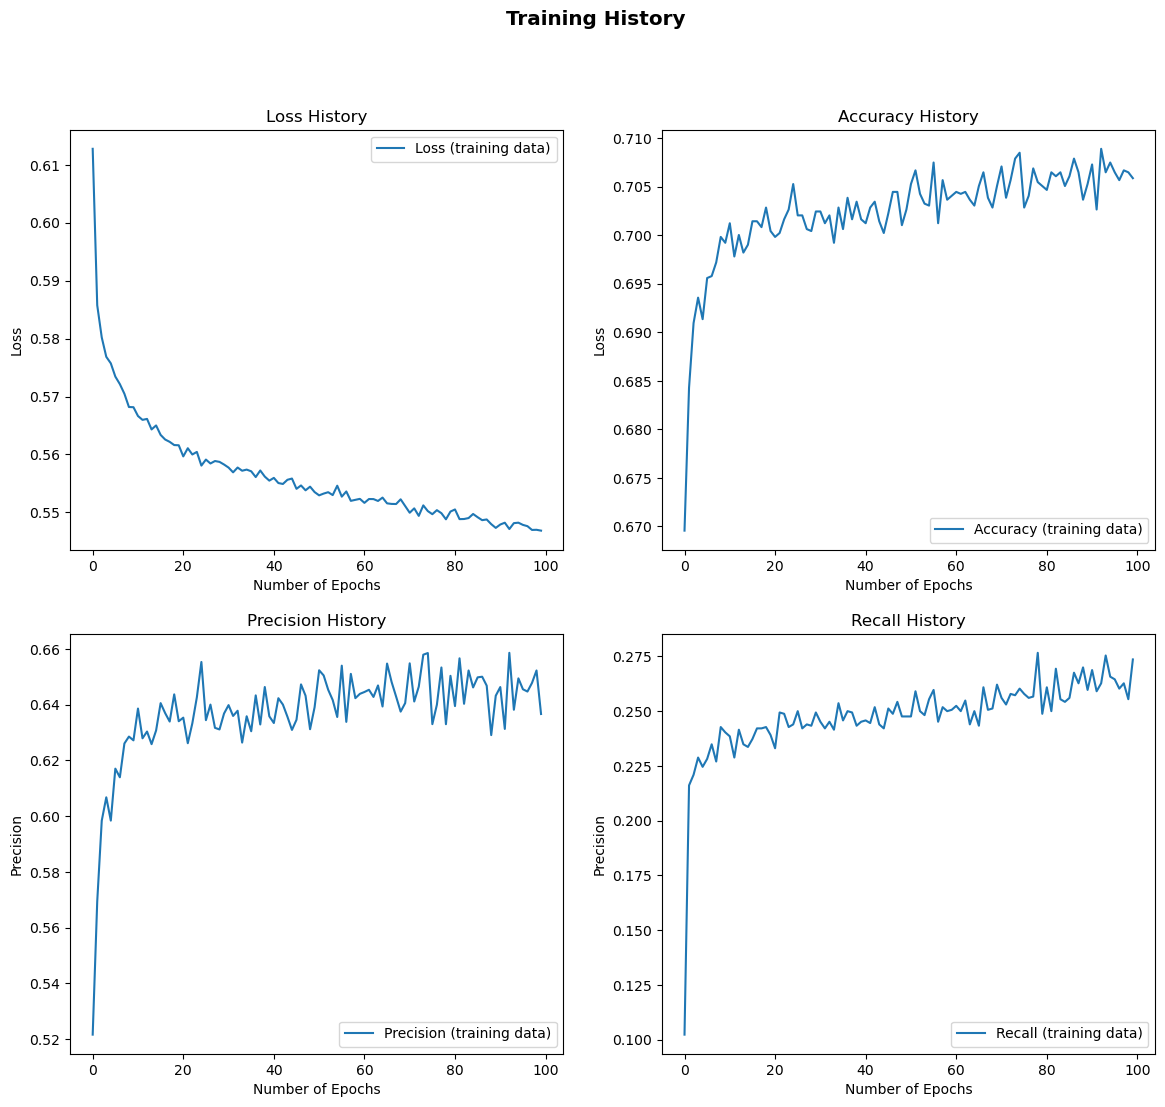

In [18]:
visualize_training_history(history)

#### Model performance on train and test sets

32/32 [==============================] - 0s 1ms/step


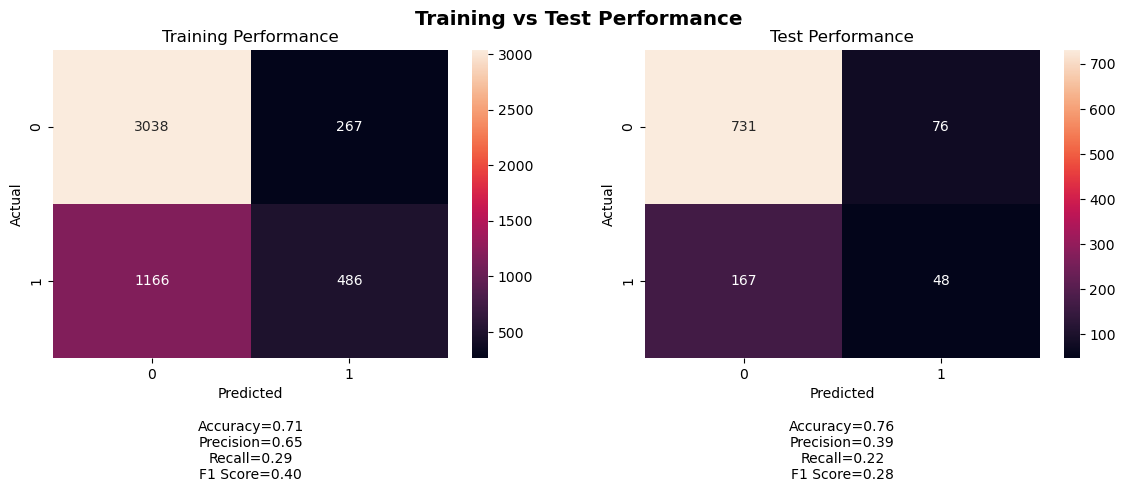

In [19]:
# Change probabilities to 0s and 1s
y_train_pred = (model.predict(X_train) >= 0.5).astype('int64')
y_test_pred = (model.predict(X_test) >= 0.5).astype('int64')

accuracy, precision, recall, f1_score = visualize_performance(y_train, y_train_pred, 
                                                              y_test, y_test_pred)

# Save values
tests_performance['Test Accuracy'].append(('Oversampling', accuracy))
tests_performance['Test Precision'].append(('Oversampling', precision))
tests_performance['Test Recall'].append(('Oversampling', recall))
tests_performance['Test F1 Score' ].append(('Oversampling', f1_score))

### 3. Third Model (SMOTETomek Resampling)

#### Data preparation

In [20]:
# Import and prepare dataset
train_stroke_data = pd.read_csv('smotetomek-train.csv', index_col=0)
train_stroke_data = train_stroke_data.drop(columns=['hypertension', 'heart_disease', 'stroke'])

test_stroke_data = pd.read_csv('test.csv', index_col=0)
test_stroke_data = test_stroke_data.drop(columns=['hypertension', 'heart_disease', 'stroke', 'gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'])

# Split into X and y
X_train, y_train = train_stroke_data.iloc[:, :-1], train_stroke_data.iloc[:, -1]
X_test, y_test = test_stroke_data.iloc[:, :-1], test_stroke_data.iloc[:, -1]

# Standardize inputs
X_train, X_test = standardize(X_train, X_test)

#### Create model

In [21]:
model = create_model([16, 16, 16], input_dim=len(X_train[0]), model_name='smotetomek-model')
model.summary()

Model: "smotetomek-model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_1 (Dense)             (None, 16)                48        
                                                                 
 Dense_2 (Dense)             (None, 16)                272       
                                                                 
 Dense_3 (Dense)             (None, 16)                272       
                                                                 
 Output (Dense)              (None, 1)                 17        
                                                                 
Total params: 609
Trainable params: 609
Non-trainable params: 0
_________________________________________________________________


#### Model training

In [22]:
# Model training
history = model.fit(X_train, y_train, batch_size=16, epochs=100)
training_histories['SMOTETomek'] = history

Epoch 1/100
373/373 [==============================] - 2s 3ms/step - loss: 0.6444 - accuracy: 0.6157 - precision: 0.5965 - recall: 0.7151
Epoch 2/100
373/373 [==============================] - 1s 3ms/step - loss: 0.6061 - accuracy: 0.6468 - precision: 0.6256 - recall: 0.7309
Epoch 3/100
373/373 [==============================] - 1s 3ms/step - loss: 0.6027 - accuracy: 0.6453 - precision: 0.6227 - recall: 0.7373
Epoch 4/100
373/373 [==============================] - 1s 2ms/step - loss: 0.6000 - accuracy: 0.6517 - precision: 0.6243 - recall: 0.7615
Epoch 5/100
373/373 [==============================] - 1s 2ms/step - loss: 0.5974 - accuracy: 0.6510 - precision: 0.6238 - recall: 0.7608
Epoch 6/100
373/373 [==============================] - 1s 2ms/step - loss: 0.5960 - accuracy: 0.6508 - precision: 0.6223 - recall: 0.7676
Epoch 7/100
373/373 [==============================] - 1s 3ms/step - loss: 0.5957 - accuracy: 0.6498 - precision: 0.6193 - recall: 0.7780
Epoch 8/100
373/373 [=============

373/373 [==============================] - 1s 3ms/step - loss: 0.5833 - accuracy: 0.6644 - precision: 0.6237 - recall: 0.8290
Epoch 61/100
373/373 [==============================] - 1s 3ms/step - loss: 0.5833 - accuracy: 0.6643 - precision: 0.6247 - recall: 0.8226
Epoch 62/100
373/373 [==============================] - 1s 3ms/step - loss: 0.5827 - accuracy: 0.6646 - precision: 0.6249 - recall: 0.8233
Epoch 63/100
373/373 [==============================] - 1s 2ms/step - loss: 0.5829 - accuracy: 0.6638 - precision: 0.6238 - recall: 0.8250
Epoch 64/100
373/373 [==============================] - 1s 3ms/step - loss: 0.5812 - accuracy: 0.6658 - precision: 0.6257 - recall: 0.8253
Epoch 65/100
373/373 [==============================] - 1s 3ms/step - loss: 0.5821 - accuracy: 0.6659 - precision: 0.6252 - recall: 0.8287
Epoch 66/100
373/373 [==============================] - 1s 2ms/step - loss: 0.5822 - accuracy: 0.6641 - precision: 0.6243 - recall: 0.8243
Epoch 67/100
373/373 [==================

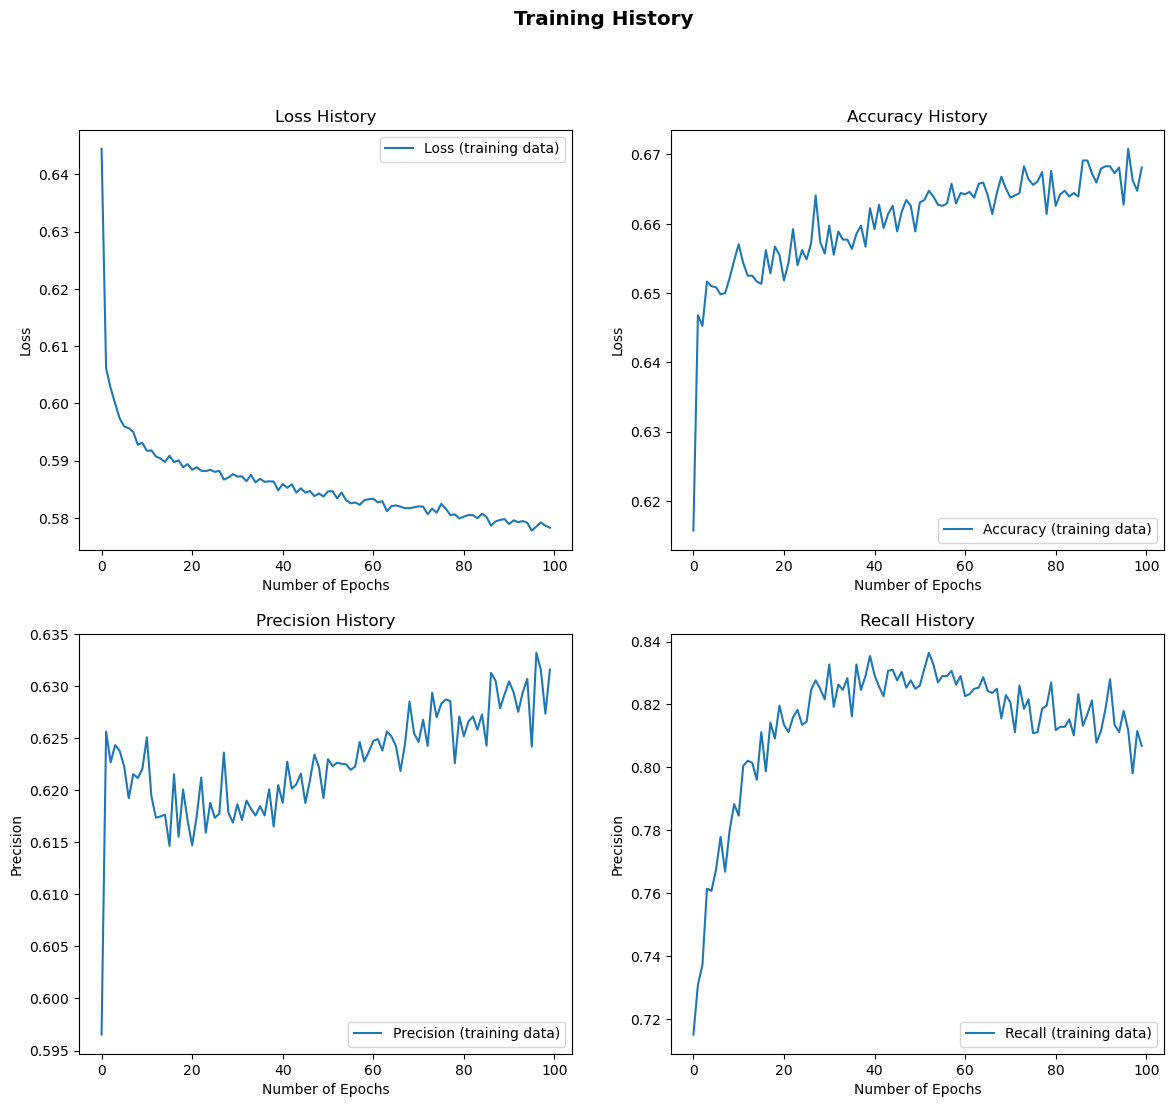

In [23]:
visualize_training_history(history)

#### Model performance on train and test sets

32/32 [==============================] - 0s 1ms/step


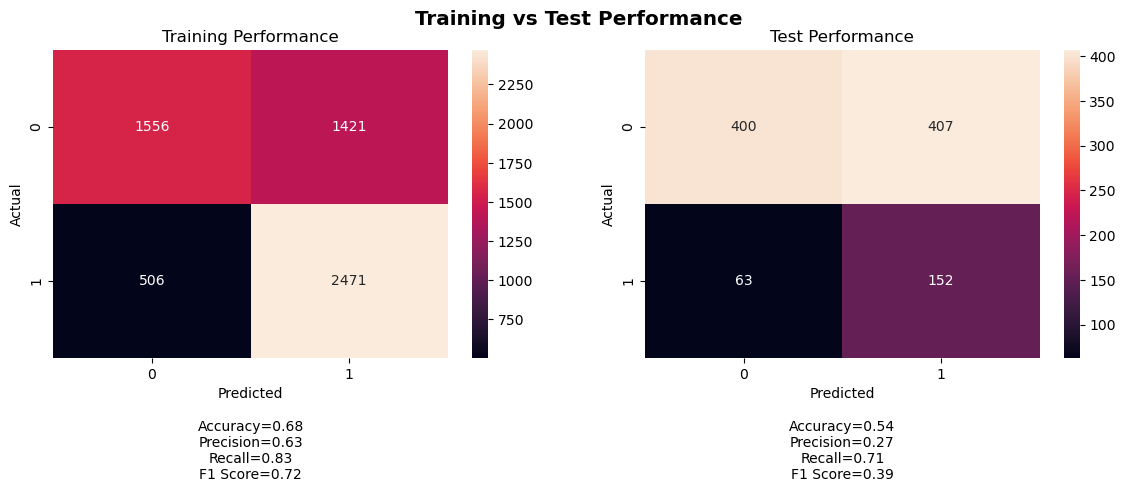

In [24]:
# Change probabilities to 0s and 1s
y_train_pred = (model.predict(X_train) >= 0.5).astype('int64')
y_test_pred = (model.predict(X_test) >= 0.5).astype('int64')

accuracy, precision, recall, f1_score = visualize_performance(y_train, y_train_pred, 
                                                              y_test, y_test_pred)

# Save values
tests_performance['Test Accuracy'].append(('SMOTETomek', accuracy))
tests_performance['Test Precision'].append(('SMOTETomek', precision))
tests_performance['Test Recall'].append(('SMOTETomek', recall))
tests_performance['Test F1 Score' ].append(('SMOTETomek', f1_score))

### 4. Fourth Model (SMOTEENN Resampling)

#### Data preparation

In [25]:
# Import and prepare dataset
train_stroke_data = pd.read_csv('smoteenn-train.csv', index_col=0)
train_stroke_data = train_stroke_data.drop(columns=['hypertension', 'heart_disease', 'stroke'])

test_stroke_data = pd.read_csv('test.csv', index_col=0)
test_stroke_data = test_stroke_data.drop(columns=['hypertension', 'heart_disease', 'stroke', 'gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'])

# Split into X and y
X_train, y_train = train_stroke_data.iloc[:, :-1], train_stroke_data.iloc[:, -1]
X_test, y_test = test_stroke_data.iloc[:, :-1], test_stroke_data.iloc[:, -1]

# Standardize inputs
X_train, X_test = standardize(X_train, X_test)

#### Create model

In [26]:
# Create NN model
model = create_model([16, 16, 16], input_dim=len(X_train[0]),
                     model_name='smoteenn-model')
model.summary()

Model: "smoteenn-model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_1 (Dense)             (None, 16)                48        
                                                                 
 Dense_2 (Dense)             (None, 16)                272       
                                                                 
 Dense_3 (Dense)             (None, 16)                272       
                                                                 
 Output (Dense)              (None, 1)                 17        
                                                                 
Total params: 609
Trainable params: 609
Non-trainable params: 0
_________________________________________________________________


#### Model training

In [27]:
history = model.fit(X_train, y_train, batch_size=16, epochs=100)
training_histories['SMOTEENN'] = history

Epoch 1/100
213/213 [==============================] - 2s 3ms/step - loss: 0.5760 - accuracy: 0.7169 - precision: 0.6907 - recall: 0.8768
Epoch 2/100
213/213 [==============================] - 1s 3ms/step - loss: 0.4935 - accuracy: 0.7446 - precision: 0.7134 - recall: 0.8934
Epoch 3/100
213/213 [==============================] - 1s 3ms/step - loss: 0.4776 - accuracy: 0.7604 - precision: 0.7400 - recall: 0.8688
Epoch 4/100
213/213 [==============================] - 1s 3ms/step - loss: 0.4716 - accuracy: 0.7604 - precision: 0.7451 - recall: 0.8565
Epoch 5/100
213/213 [==============================] - 1s 2ms/step - loss: 0.4691 - accuracy: 0.7654 - precision: 0.7440 - recall: 0.8731
Epoch 6/100
213/213 [==============================] - 1s 3ms/step - loss: 0.4662 - accuracy: 0.7619 - precision: 0.7417 - recall: 0.8688
Epoch 7/100
213/213 [==============================] - 1s 3ms/step - loss: 0.4645 - accuracy: 0.7666 - precision: 0.7462 - recall: 0.8709
Epoch 8/100
213/213 [=============

213/213 [==============================] - 1s 3ms/step - loss: 0.4312 - accuracy: 0.7828 - precision: 0.7491 - recall: 0.9084
Epoch 61/100
213/213 [==============================] - 1s 3ms/step - loss: 0.4322 - accuracy: 0.7769 - precision: 0.7480 - recall: 0.8950
Epoch 62/100
213/213 [==============================] - 1s 3ms/step - loss: 0.4287 - accuracy: 0.7842 - precision: 0.7517 - recall: 0.9063
Epoch 63/100
213/213 [==============================] - 1s 3ms/step - loss: 0.4298 - accuracy: 0.7757 - precision: 0.7471 - recall: 0.8939
Epoch 64/100
213/213 [==============================] - 1s 3ms/step - loss: 0.4305 - accuracy: 0.7807 - precision: 0.7472 - recall: 0.9073
Epoch 65/100
213/213 [==============================] - 1s 3ms/step - loss: 0.4300 - accuracy: 0.7804 - precision: 0.7523 - recall: 0.8945
Epoch 66/100
213/213 [==============================] - 1s 3ms/step - loss: 0.4290 - accuracy: 0.7804 - precision: 0.7469 - recall: 0.9073
Epoch 67/100
213/213 [==================

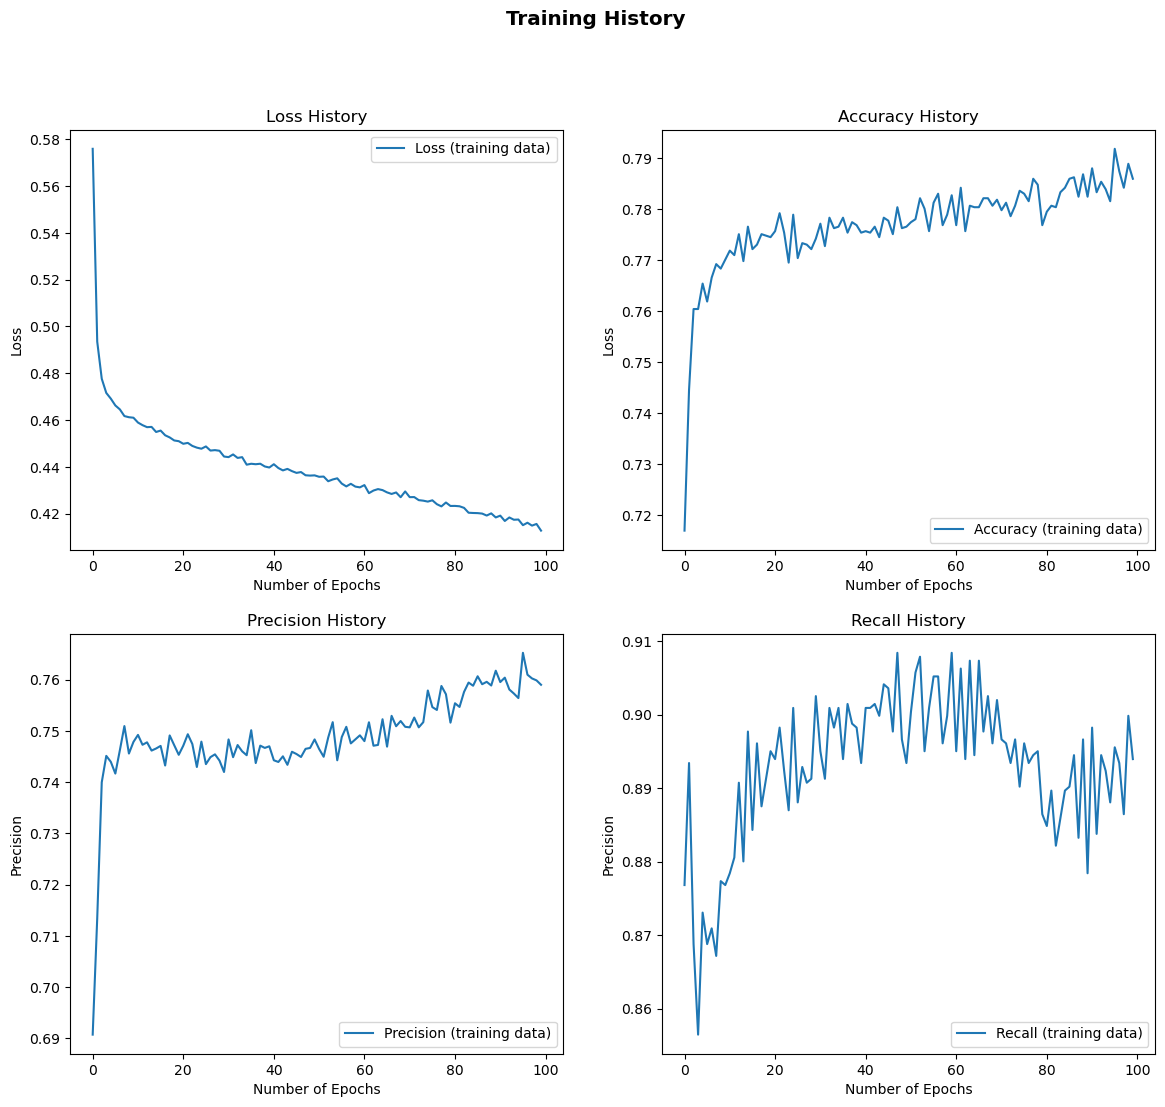

In [28]:
visualize_training_history(history)

#### Model performance on train and test sets

32/32 [==============================] - 0s 2ms/step


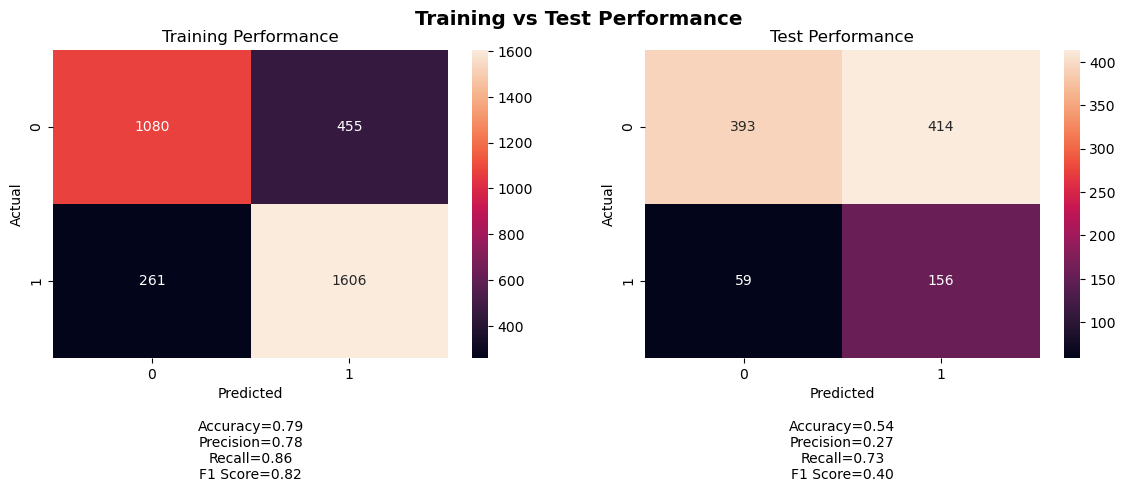

In [29]:
# Change probabilities to 0s and 1s
y_train_pred = (model.predict(X_train) >= 0.5).astype('int64')
y_test_pred = (model.predict(X_test) >= 0.5).astype('int64')

accuracy, precision, recall, f1_score = visualize_performance(y_train, y_train_pred, 
                                                              y_test, y_test_pred)

# Save values
tests_performance['Test Accuracy'].append(('SMOTEENN', accuracy))
tests_performance['Test Precision'].append(('SMOTEENN', precision))
tests_performance['Test Recall'].append(('SMOTEENN', recall))
tests_performance['Test F1 Score' ].append(('SMOTEENN', f1_score))

### Comparing performance between different resampling methods

#### Performance on test set

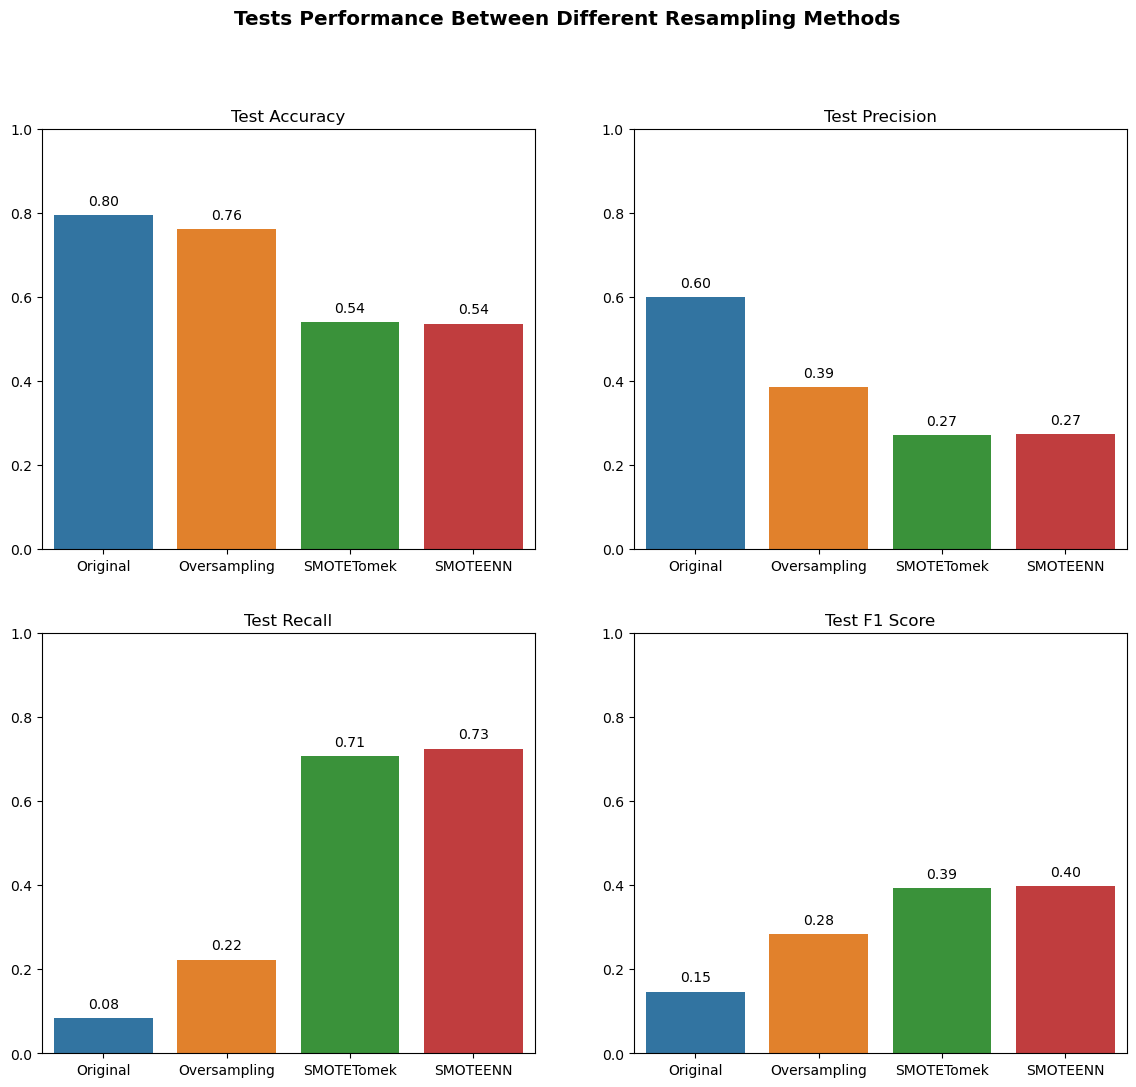

In [30]:
visualize_tests_performance(tests_performance)

#### Training histories

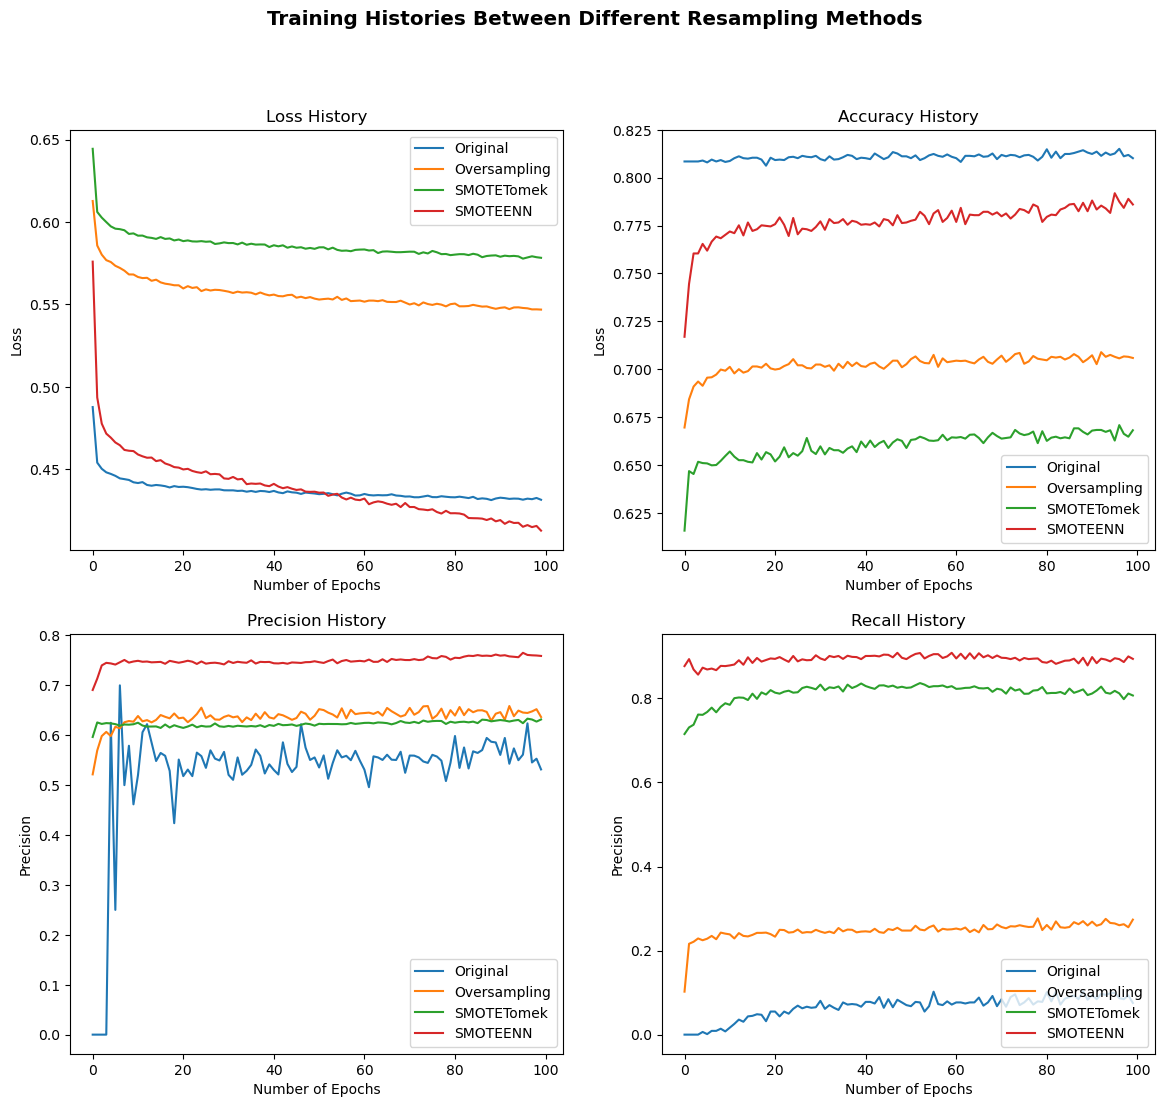

In [31]:
visualize_multiple_training_histories(training_histories)

### Comparing performance on test set multiple times

Since training neural networks are stochastic by design (different training, different results), we should not conclude the effectiveness of a resampling method by just doing a single test.

In [32]:
# Redo the process multiple times and count the winners
winner_count = repeat_train_and_test(iterations=100)

# Save the result into a json file
with open('winner-data.json', 'w') as f:
    json.dump(winner_count, f)

  0%|          | 0/100 [00:00<?, ?it/s]

32/32 [==============================] - 0s 2ms/step


  1%|          | 1/100 [04:15<7:01:08, 255.24s/it]

32/32 [==============================] - 0s 1ms/step


  2%|▏         | 2/100 [09:20<7:44:50, 284.60s/it]

32/32 [==============================] - 0s 1ms/step


  3%|▎         | 3/100 [13:33<7:17:07, 270.39s/it]

32/32 [==============================] - 0s 2ms/step


  4%|▍         | 4/100 [19:19<8:00:23, 300.24s/it]

32/32 [==============================] - 0s 2ms/step


  5%|▌         | 5/100 [24:39<8:06:36, 307.33s/it]

32/32 [==============================] - 0s 2ms/step


  6%|▌         | 6/100 [29:47<8:01:46, 307.52s/it]

32/32 [==============================] - 0s 2ms/step


  7%|▋         | 7/100 [34:39<7:48:33, 302.29s/it]

32/32 [==============================] - 0s 2ms/step


  7%|▋         | 7/100 [38:37<8:33:15, 331.14s/it]


KeyboardInterrupt: 

In [ ]:
# Load json file
with open('winner-data.json') as f:
    winner_count = json.load(f)
    
visualize_winner_count(winner_count)